# [XGBoost](https://www.coursera.org/learn/used-car-price-prediction-using-machine-learning-models/)

- [Paper: XGBoost: A Scalable Tree Boosting System](https://arxiv.org/pdf/1603.02754.pdf)
- [Docs](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)


## Used Car Price Prediction

- Inputs: Used car make, model, type, origin, drivetrain, invoice, engine size, cylinders, horse power, MPG city, MPG highway, weight, wheelbase, length
- Output: MSRP (price)

### Import Libraries


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

In [2]:
import pathlib
import os

DATA_PATH = pathlib.Path(os.getcwd()).parent / "data" / "used_cars.csv"

SEED = RANDOM_STATE = 3

### Load Data

In [3]:
data = pd.read_csv(DATA_PATH)

data.head()

,Make,Model,Type,Origin,DriveTrain,MSRP,Invoice,EngineSize,Cylinders,Horsepower,MPG_City,MPG_Highway,Weight,Wheelbase,Length
0,Acura,MDX,SUV,Asia,All,"$36,945","$33,337",3.5,6.0,265,17,23,4451,106,189
1,Acura,RSX Type S 2dr,Sedan,Asia,Front,"$23,820","$21,761",2.0,4.0,200,24,31,2778,101,172
2,Acura,TSX 4dr,Sedan,Asia,Front,"$26,990","$24,647",2.4,4.0,200,22,29,3230,105,183
3,Acura,TL 4dr,Sedan,Asia,Front,"$33,195","$30,299",3.2,6.0,270,20,28,3575,108,186
4,Acura,3.5 RL 4dr,Sedan,Asia,Front,"$43,755","$39,014",3.5,6.0,225,18,24,3880,115,197


In [4]:
data.columns

Index(['Make', 'Model', 'Type', 'Origin', 'DriveTrain', 'MSRP', 'Invoice',
       'EngineSize', 'Cylinders', 'Horsepower', 'MPG_City', 'MPG_Highway',
       'Weight', 'Wheelbase', 'Length'],
      dtype='object')

In [5]:
data.shape

(428, 15)

### Clean Data

In [6]:
data.isna().sum()

Make           0
Model          0
Type           0
Origin         0
DriveTrain     0
MSRP           0
Invoice        0
EngineSize     0
Cylinders      2
Horsepower     0
MPG_City       0
MPG_Highway    0
Weight         0
Wheelbase      0
Length         0
dtype: int64

In [7]:
data.dropna(inplace=True)

data.isna().sum()

Make           0
Model          0
Type           0
Origin         0
DriveTrain     0
MSRP           0
Invoice        0
EngineSize     0
Cylinders      0
Horsepower     0
MPG_City       0
MPG_Highway    0
Weight         0
Wheelbase      0
Length         0
dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 426 entries, 0 to 427
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Make         426 non-null    object 
 1   Model        426 non-null    object 
 2   Type         426 non-null    object 
 3   Origin       426 non-null    object 
 4   DriveTrain   426 non-null    object 
 5   MSRP         426 non-null    object 
 6   Invoice      426 non-null    object 
 7   EngineSize   426 non-null    float64
 8   Cylinders    426 non-null    float64
 9   Horsepower   426 non-null    int64  
 10  MPG_City     426 non-null    int64  
 11  MPG_Highway  426 non-null    int64  
 12  Weight       426 non-null    int64  
 13  Wheelbase    426 non-null    int64  
 14  Length       426 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 53.2+ KB


In [9]:
def parse_currency_to_int(df: pd.DataFrame, *cols: str) -> None:
    for col in cols:
        df[col] = df[col].str.replace("$", "")
        df[col] = df[col].str.replace(",", "")
        df[col] = df[col].astype(int)

In [10]:
parse_currency_to_int(data, "MSRP", "Invoice")

data.head()

,Make,Model,Type,Origin,DriveTrain,MSRP,Invoice,EngineSize,Cylinders,Horsepower,MPG_City,MPG_Highway,Weight,Wheelbase,Length
0,Acura,MDX,SUV,Asia,All,36945,33337,3.5,6.0,265,17,23,4451,106,189
1,Acura,RSX Type S 2dr,Sedan,Asia,Front,23820,21761,2.0,4.0,200,24,31,2778,101,172
2,Acura,TSX 4dr,Sedan,Asia,Front,26990,24647,2.4,4.0,200,22,29,3230,105,183
3,Acura,TL 4dr,Sedan,Asia,Front,33195,30299,3.2,6.0,270,20,28,3575,108,186
4,Acura,3.5 RL 4dr,Sedan,Asia,Front,43755,39014,3.5,6.0,225,18,24,3880,115,197


### EDA

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 426 entries, 0 to 427
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Make         426 non-null    object 
 1   Model        426 non-null    object 
 2   Type         426 non-null    object 
 3   Origin       426 non-null    object 
 4   DriveTrain   426 non-null    object 
 5   MSRP         426 non-null    int64  
 6   Invoice      426 non-null    int64  
 7   EngineSize   426 non-null    float64
 8   Cylinders    426 non-null    float64
 9   Horsepower   426 non-null    int64  
 10  MPG_City     426 non-null    int64  
 11  MPG_Highway  426 non-null    int64  
 12  Weight       426 non-null    int64  
 13  Wheelbase    426 non-null    int64  
 14  Length       426 non-null    int64  
dtypes: float64(2), int64(8), object(5)
memory usage: 53.2+ KB


In [12]:
data["MSRP"].min(), data["MSRP"].max()

(10280, 192465)

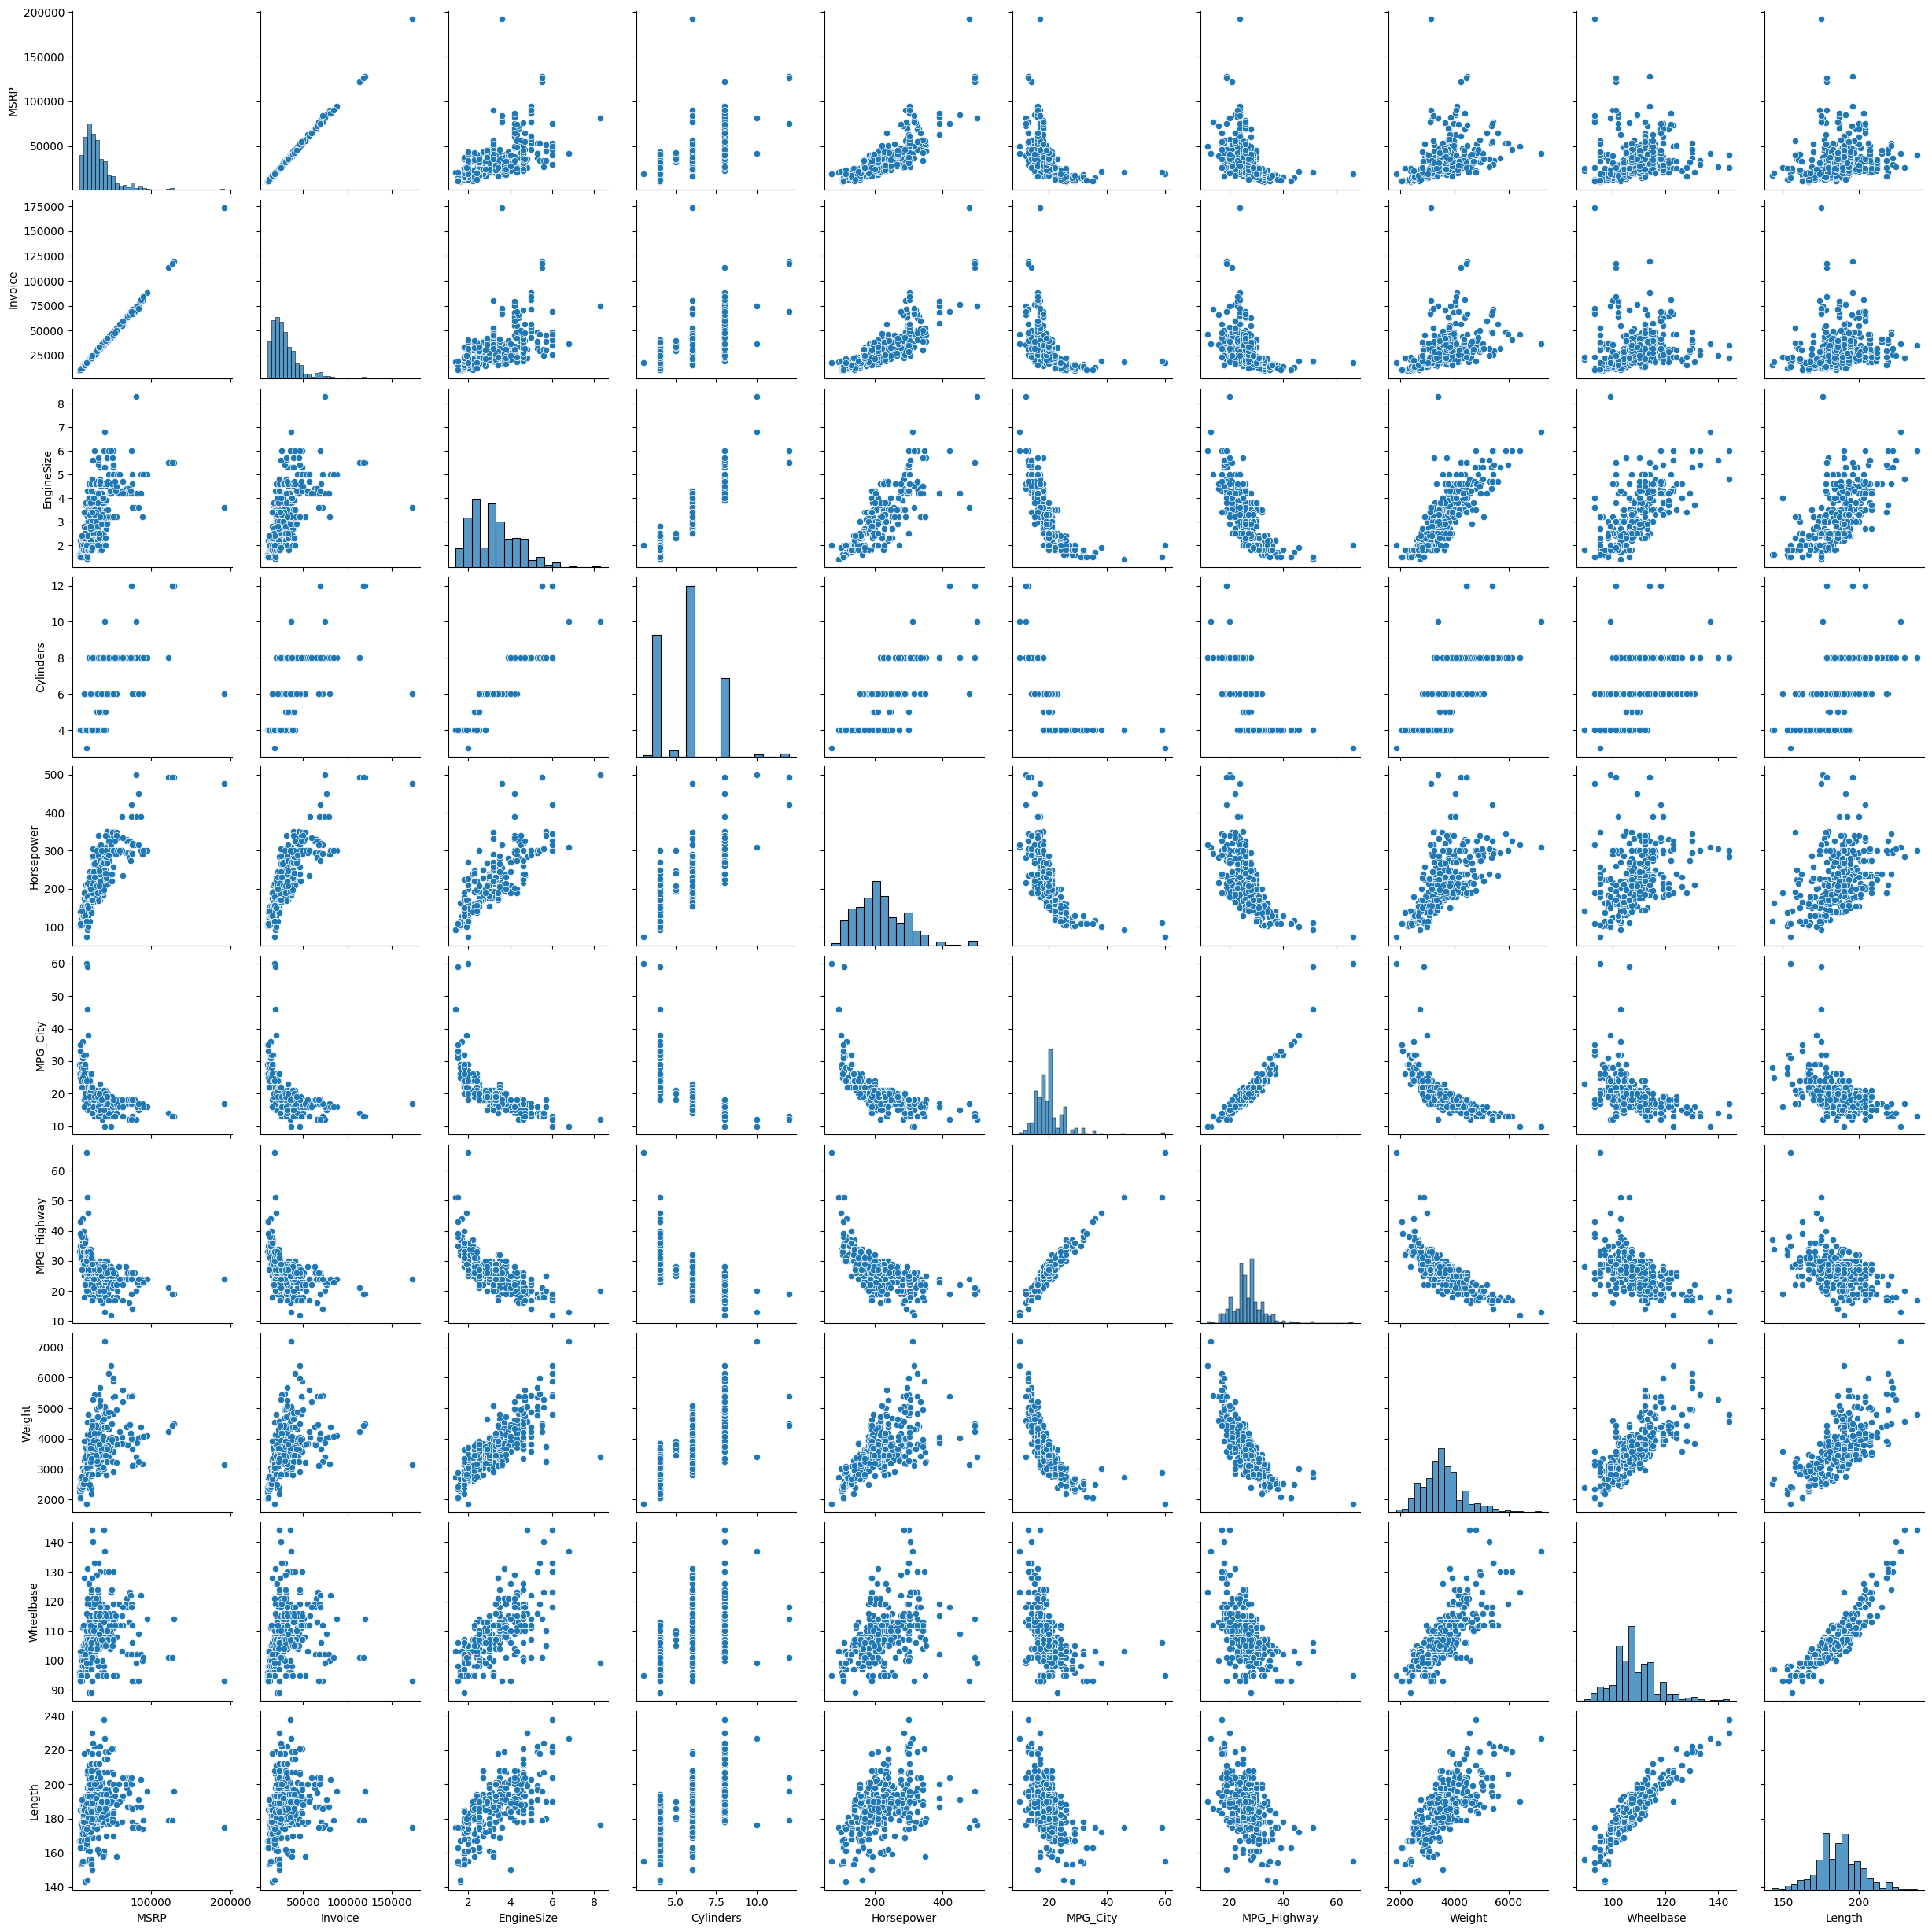

In [13]:
sns.pairplot(data=data);

In [14]:
for col in ["Make", "Type", "Origin", "DriveTrain"]:
    px.histogram(data, x=col).show()

In [15]:
px.histogram(data, x="Make", color="Origin").show()
px.histogram(data, x="Make", color="Type").show()

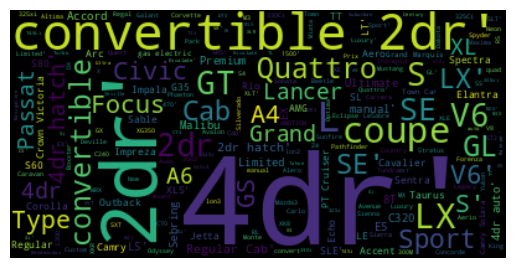

In [16]:
word_cloud = WordCloud(
    stopwords=STOPWORDS,
    max_words=2000,
    max_font_size=100,
    random_state=RANDOM_STATE,
).generate(str(data["Model"].values))

plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [17]:
def plot_correlation(df: pd.DataFrame) -> None:
    correlation_matrix = df.select_dtypes(include="number").corr()

    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")

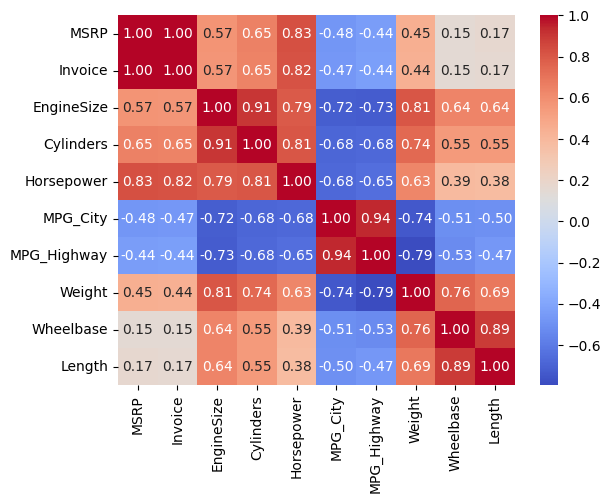

In [18]:
plot_correlation(data)

### Prepare Data

In [19]:
data.drop("Invoice", axis=1, inplace=True)  # Highly correlated with MSRP

In [20]:
def one_hot(df: pd.DataFrame) -> pd.DataFrame:
    return pd.get_dummies(
        df,
        columns=df.select_dtypes(include=["object"]).columns.tolist(),
    )

In [21]:
data = one_hot(data)

data.head()

,MSRP,EngineSize,Cylinders,Horsepower,MPG_City,MPG_Highway,Weight,Wheelbase,Length,Make_Acura,...,Type_Sedan,Type_Sports,Type_Truck,Type_Wagon,Origin_Asia,Origin_Europe,Origin_USA,DriveTrain_All,DriveTrain_Front,DriveTrain_Rear
0,36945,3.5,6.0,265,17,23,4451,106,189,True,...,False,False,False,False,True,False,False,True,False,False
1,23820,2.0,4.0,200,24,31,2778,101,172,True,...,True,False,False,False,True,False,False,False,True,False
2,26990,2.4,4.0,200,22,29,3230,105,183,True,...,True,False,False,False,True,False,False,False,True,False
3,33195,3.2,6.0,270,20,28,3575,108,186,True,...,True,False,False,False,True,False,False,False,True,False
4,43755,3.5,6.0,225,18,24,3880,115,197,True,...,True,False,False,False,True,False,False,False,True,False


In [22]:
data.isna().sum()

MSRP                0
EngineSize          0
Cylinders           0
Horsepower          0
MPG_City            0
                   ..
Origin_Europe       0
Origin_USA          0
DriveTrain_All      0
DriveTrain_Front    0
DriveTrain_Rear     0
Length: 482, dtype: int64

### Split Data

In [23]:
X, y = np.array(data.drop("MSRP", axis=1)), np.array(data["MSRP"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

### Train and Evaluate Models

                   Model R2 Score      MAE      RMSE           MSE
0       LinearRegression     0.82  6224.60   9521.55   90659856.89
1  DecisionTreeRegressor     0.54  6510.31  15204.35  231172278.78
2  RandomForestRegressor     0.82  5259.88   9438.53   89085828.17
3           XGBRegressor     0.78  5361.11  10612.56  112626523.60


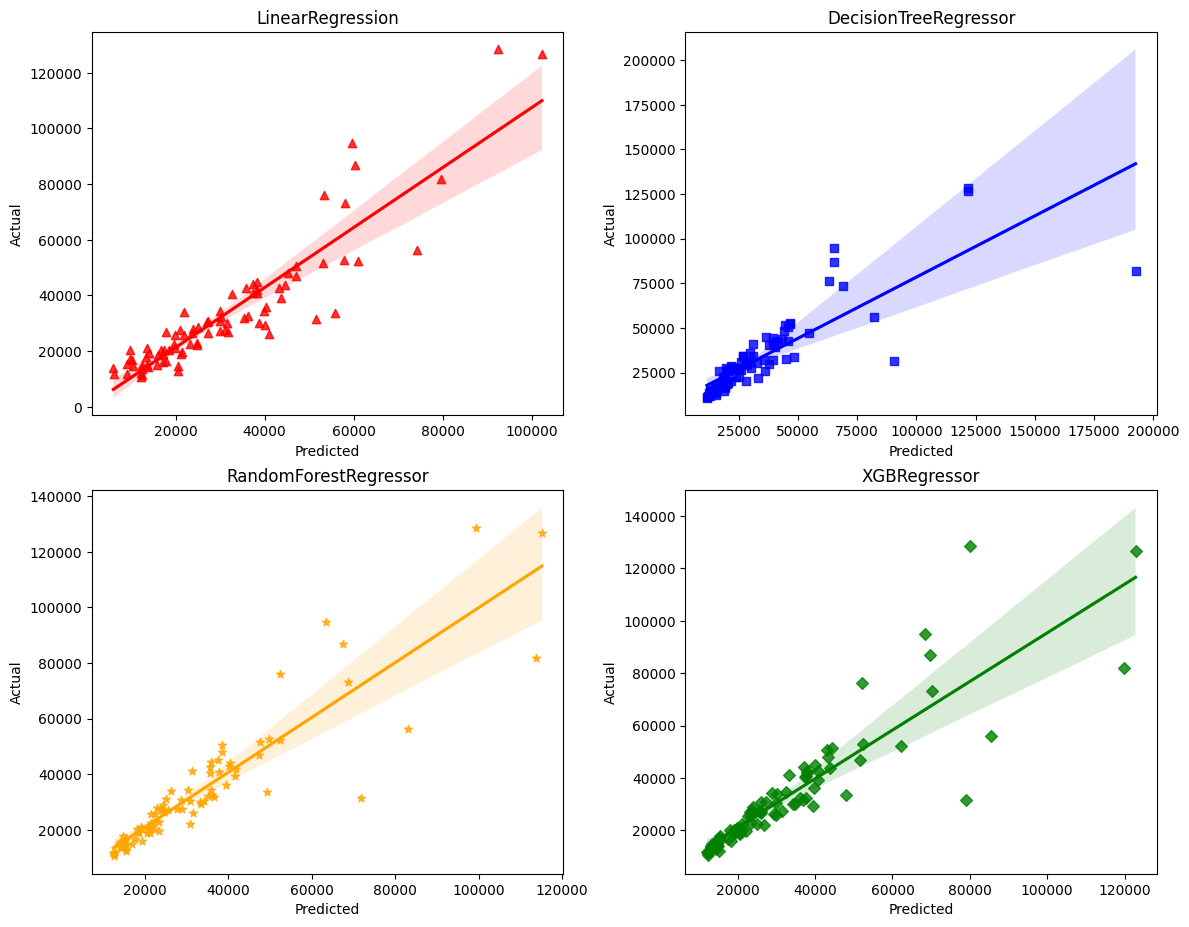

In [24]:
metrics = {"Model": [], "R2 Score": [], "MAE": [], "RMSE": [], "MSE": []}

models = [
    (LinearRegression(), "red", "^"),
    (DecisionTreeRegressor(), "blue", "s"),
    (RandomForestRegressor(), "orange", "*"),
    (XGBRegressor(), "green", "D"),
]

_, axes = plt.subplots(2, 2, figsize=(12, 10))

for (model, colour, marker), ax in zip(models, axes.ravel()):
    model_name = model.__class__.__name__
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    sns.regplot(x=y_pred, y=y_test, color=colour, marker=marker, ax=ax)
    ax.set(xlabel="Predicted", ylabel="Actual", title=model_name)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    metrics["Model"].append(model_name)
    metrics["R2 Score"].append(r2)
    metrics["MAE"].append(mae)
    metrics["RMSE"].append(rmse)
    metrics["MSE"].append(mse)

metrics_df = pd.DataFrame(metrics)
for metrics_col in metrics_df.columns[1:]:
    metrics_df[metrics_col] = metrics_df[metrics_col].apply(lambda x: f"{x:.2f}")

print(metrics_df)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()